In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

# 1 导入Label

以文本文件格式读入文件夹\dataanalysis\label\下的MTL_Male.dat, CMTL_Male.dat, CEMTL_Male.dat中数据，并且分别读入numpy数组MTLLabel、CMTLLabel或者CEMTLLabel中，对各个数组取绝对值后按照降序排序，并且记录数据元素排序前的下标号。

## 1.1 文件导入

将Label文件夹下的MTLLabel、CMTLLabel和CEMTLLabel三个数据进行导入，其分割符号为回车。

In [2]:
MTLLabel = np.loadtxt("dataanalysis/label/MTL_Male.dat", dtype=np.float64, delimiter="\n")
CMTLLabel = np.loadtxt("dataanalysis/label/CMTL_Male.dat", dtype=np.float64, delimiter="\n")
CEMTLLabel = np.loadtxt("dataanalysis/label/CEMTL_Male.dat", dtype=np.float64, delimiter="\n")

## 1.2 排序

通过np.argsort，可以获取到排序后元素在原序列中的下标。
由于numpy中没有设置排序顺序的参数，因此可以通过先将原向量取反进行排序，排序完成后再取反，即可得到降序排序。

In [3]:
MTLLabel_sorted = np.abs(MTLLabel)
MTLLabel_index = np.argsort(-MTLLabel_sorted)
MTLLabel_sorted = np.abs(np.sort(-MTLLabel_sorted))
CMTLLabel_sorted = np.abs(CMTLLabel)
CMTLLabel_index = np.argsort(-CMTLLabel_sorted)
CMTLLabel_sorted = np.abs(np.sort(-CMTLLabel_sorted))
CEMTLLabel_sorted = np.abs(CEMTLLabel)
CEMTLLabel_index = np.argsort(-CEMTLLabel_sorted)
CEMTLLabel_sorted = np.abs(np.sort(-CEMTLLabel_sorted))

# 2 导入Train

文本文件格式读入文件夹\dataanalysis\train\下的MTL_Male_train.dat中的数据，并且读入numpy矩阵TrainSample中，计算矩阵的行列数（该矩阵包含了1000个维数为3304的样本的观测值，第1-500个样本属于第一类，第501-1000个样本属于第二类，每类含500个样本顺序保存在文件中)。根据(1)中数组的排序（3个数组分别实验），选择最大的k个值（k 取200，400，600，800，1000，...3304维)对应的维度，把TrainSample中的1000个样本降维为k维，并保存到新的矩阵中TrainSub中。

## 2.1 文件导入

将MTL_Male_train.dat导入到numpy矩阵TrainSample中。

In [4]:
TrainSample = np.loadtxt("dataanalysis/train/MTL_Male_train.dat", dtype=int, delimiter=",")

矩阵的大小如下：

In [5]:
TrainSample.shape

(1000, 3304)

## 2.2 降低维度

编写函数，使得其能够从传入的index数组中一次读取列号，将其依次作为数据的列号，从TrainSample中读取数据，并且保存到新的矩阵中TrainSub中。
在这里仅编写降低维度的函数，实际操作在(4)中会调用这里的函数。

In [6]:
def reduce_dimension(target: np.ndarray, index: np.ndarray, k: int):
    column = [index[i] for i in range(k)]
    return target[:, column]

# 3 导入测试数据

对于\dataanalysis\test\下文件作和(2)相同的处理（其中数据矩阵包含了800个维数为3304的样本，第1-400个样本属于第一类，第401-800个样本 属于第二类，每类含400个样本顺序保存在文件中）。

In [7]:
TestSample = np.loadtxt("dataanalysis/test/MTL_Male_test.dat", dtype=int, delimiter=",")

测试数据的维度为：

In [8]:
TestSample.shape

(800, 3304)

# 4 分类

阅读和学习\knnexample\下面关于最近邻分类算法Knn的实现，用(2)中数据训练分类模型，用(3)中数据测试分类结果，统计错误率。

# 4.1 分类函数

在这里分别有Classify和ClassifyAllCases两个函数。前者是对单条数据进行分类，后者是将测试集中所有的数据调用第一个函数进行测试，随后打印错误率和正确率。

In [9]:
def ClassifyOneCase(train: np.ndarray, case: np.ndarray, point: int):
    class_1 = 0
    class_2 = 0
    distance = np.sum(((train - case) ** 2), axis=1) ** 0.5
    ndx = np.argsort(distance)

    for j in range(point):
        if 0 <= ndx[j] < 500:
            class_1 += 1
        else:
            class_2 += 1

    if class_1 > class_2:
        return 1
    elif class_1 < class_2:
        return 2
    else:
        return 0

In [10]:
def ClassifyAllCases(train: np.ndarray, test: np.ndarray, dim: int, point: int):
    testcase = test.size // dim
    cor = 0
    err = 0
    for case in range(testcase):
        result = ClassifyOneCase(train, test[case], point)
        if 0 <= case < testcase // 2:
            if result == 1 or result == 0:
                cor += 1
            else:
                err += 1
        else:
            if result == 2 or result == 0:
                cor += 1
            else:
                err += 1

    correct_rate = cor / testcase
    error_rate = err / testcase
    return correct_rate, error_rate

## 4.2 设置参数

在对模型进行训练前，有若干个参数需要进行调整，分别为：

- source: 选择哪一个集合的列号进行降维，可选[MTLLabel_index, CMTLLabel_index, CEMTLLabel_index]
- dimension: 降维后的维数，取值范围为[1, 3304]，默认为200
- k: Knn中看的最近的k个点

在这里统一进行调整的主要原因是因为需要让测试集和训练集保持一致。

设置完成后，对数据进行降维。

In [11]:
source = np.copy(MTLLabel_index)
dimension = 200
k = 5

# 4.3 进行分类

调用之前的函数，进行分类。

In [12]:
def Classify(train: np.ndarray, test: np.ndarray, label: np.ndarray, dim: int, point: int):
    train_sub = reduce_dimension(train, label, dim)
    test_sub = reduce_dimension(test, label, dim)
    return ClassifyAllCases(train_sub, test_sub, dim, point)

In [13]:
correct, error = Classify(TrainSample, TestSample, source, dimension, k)
print("Correct rate: {}".format(correct))
print("Error rate: {}".format(error))

Correct rate: 0.92875
Error rate: 0.07125


# 5 参数分析

# 5.1 与k的关系

  0%|          | 0/1000 [00:00<?, ?it/s]

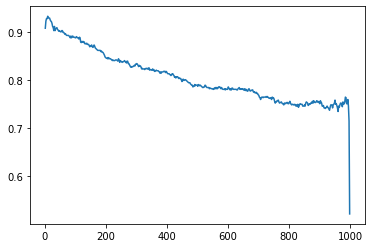

In [14]:
x = []
y = []
pbar = tqdm(total=1000)
for i in range(1, 1000, 2):
    x.append(i)
    correct, _ = Classify(TrainSample, TestSample, source, dimension, i)
    y.append(correct)
    pbar.update(2)

pbar.close()
plt.plot(x, y)
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

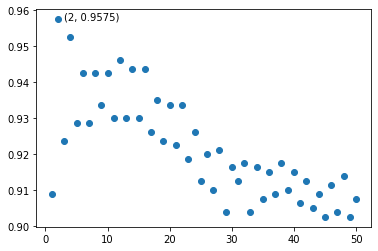

In [15]:
dic = {}
pbar = tqdm(total=50)
for i in range(1, 51):
    correct, _ = Classify(TrainSample, TestSample, source, dimension, i)
    dic[i] = correct
    pbar.update(1)

pbar.close()
x = list(dic.keys())
y = list(dic.values())
x_max = max(dic, key=dic.get)
y_max = dic[x_max]
plt.scatter(x, y)
plt.text(x_max + 1, y_max, "({}, {})".format(x_max, y_max))
plt.show()

# 5.2 维度大小

  0%|          | 0/17 [00:00<?, ?it/s]

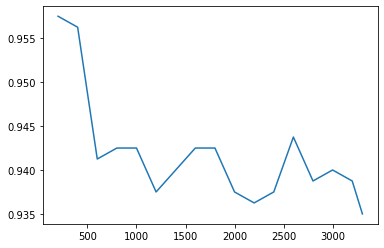

In [16]:
dim = [x for x in range(200, 3304, 200)]
dim.append(3304)
x = []
y = []
pbar = tqdm(total=17)
for i in dim:
    x.append(i)
    correct, _ = Classify(TrainSample, TestSample, source, i, 2)
    y.append(correct)
    pbar.update(1)
pbar.close()
plt.plot(x, y)
plt.show()
